## Installing Efficientnet from pytorch

In [1]:
!pip install efficientnet-pytorch -qqq

## Importing all the libraries

In [2]:
from fastai.vision.all import *
import albumentations
from efficientnet_pytorch import EfficientNet

## Data Augmentation

### CutMix from fastai library

In [3]:
from fastai.basics import *
from torch.distributions.beta import Beta


def reduce_loss(loss, reduction='mean'):
    "Reduce the loss based on `reduction`"
    return loss.mean() if reduction == 'mean' else loss.sum() if reduction == 'sum' else loss


class MixHandler(Callback):
    "A handler class for implementing `MixUp` style scheduling"
    run_valid = False
    def __init__(self, alpha=0.5):
        self.distrib = Beta(tensor(alpha), tensor(alpha))

    def before_fit(self):
        self.stack_y = getattr(self.learn.loss_func, 'y_int', False)
        if self.stack_y: self.old_lf,self.learn.loss_func = self.learn.loss_func,self.loss_func

    def after_fit(self):
        if self.stack_y: self.learn.loss_func = self.old_lf

    def lf(self, pred, *yb):
        if not self.training: return self.old_lf(pred, *yb)
        with NoneReduce(self.old_lf) as lf:
            loss = torch.lerp(lf(pred,*self.yb1), lf(pred,*yb), self.lam)
        return reduce_loss(loss, getattr(self.old_lf, 'reduction', 'mean'))

In [4]:
class CutMix(MixHandler):
    "Implementation of `https://arxiv.org/abs/1905.04899`"
    def __init__(self, alpha=1.): super().__init__(alpha)
    def before_batch(self):
        bs, _, H, W = self.x.size()
        self.lam = self.distrib.sample((1,))
        shuffle = torch.randperm(bs)
        xb1,self.yb1 = self.x[shuffle], tuple((self.y[shuffle],))
        x1, y1, x2, y2 = self.rand_bbox(W, H, self.lam)
        self.learn.xb[0][..., y1:y2, x1:x2] = xb1[..., y1:y2, x1:x2]
        self.lam = (1 - ((x2-x1)*(y2-y1))/float(W*H)).item()
        if not self.stack_y:
            ny_dims = len(self.y.size())
            self.learn.yb = tuple(L(self.yb1,self.yb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=ny_dims-1)))

    def rand_bbox(self, W, H, lam):
        cut_rat = torch.sqrt(1. - lam)
        cut_w = torch.round(W * cut_rat).type(torch.long)
        cut_h = torch.round(H * cut_rat).type(torch.long)
        # uniform
        cx = torch.randint(0, W, (1,))
        cy = torch.randint(0, H, (1,))
        x1 = torch.clamp(cx - cut_w // 2, 0, W)
        y1 = torch.clamp(cy - cut_h // 2, 0, H)
        x2 = torch.clamp(cx + cut_w // 2, 0, W)
        y2 = torch.clamp(cy + cut_h // 2, 0, H)
        return x1, y1, x2, y2

### Defining Albumentations Transform

In [5]:
class AlbumentationsTransform(RandTransform):
    split_idx,order = None,2
    
    def __init__(self,train_aug,valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
        
    def encodes(self, img:PILImage):
        if self.idx == 0 :
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [6]:
def get_train_aug(): return albumentations.Compose([
    albumentations.RandomResizedCrop(512,512),
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.ShiftScaleRotate(p=0.5),
    albumentations.HueSaturationValue(
        hue_shift_limit = 0.2,
        sat_shift_limit = 0.2,
        val_shift_limit = 0.2,
        p=0.5
    ),
    albumentations.RandomBrightnessContrast(
        brightness_limit=(-0.1,0.1),
        contrast_limit=(-0.1,0.1),
        p=0.5
    ),
    albumentations.CoarseDropout(p=0.5),
    albumentations.Cutout(p=0.5)
])

In [7]:
def get_valid_aug(): return albumentations.Compose([
    albumentations.CenterCrop(512,512,p=1.),
    albumentations.Resize(512,512)
],p=1.)

## Getting Data and Creating the DataBlock

In [8]:
set_seed(72)

In [9]:
data_path = Path('../input/cassava-leaf-disease-classification')
train_df = pd.read_csv(data_path/'train.csv')
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df['image_id'] = train_df['image_id'].apply(lambda x: f'train_images/{x}')
train_df.head()

,image_id,label
0,train_images/1546870332.jpg,0
1,train_images/251635361.jpg,3
2,train_images/3003859169.jpg,1
3,train_images/1797517154.jpg,3
4,train_images/4216173282.jpg,1


In [10]:
train_df['label'].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [11]:
def get_x(row): return data_path/row['image_id']
def get_y(row): return row['label']

In [12]:
item_tfms = AlbumentationsTransform(get_train_aug(), get_valid_aug())

In [13]:
dblock = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_x=get_x,
    splitter=RandomSplitter(seed=72),
    get_y=get_y,
    item_tfms=item_tfms,
    batch_tfms = [Normalize.from_stats(*imagenet_stats)]
)

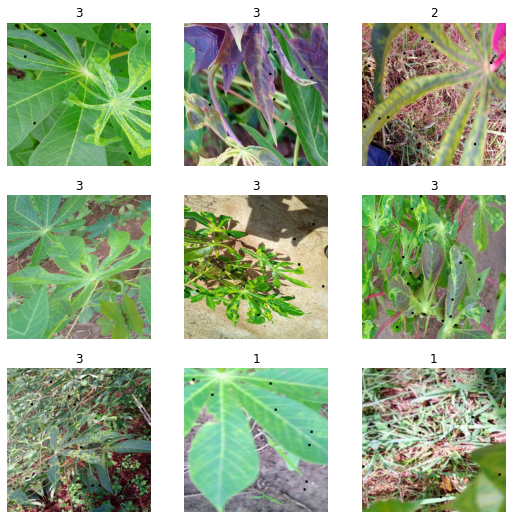

In [14]:
dls = dblock.dataloaders(train_df,bs=32,val_bs=32)
dls.show_batch()

In [15]:
#Taken from https://www.kaggle.com/muellerzr/recreating-abhishek-s-tez-with-fastai
class LeafModel(Module):
    def __init__(self, num_classes):

        self.effnet = EfficientNet.from_pretrained("efficientnet-b3")
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(1536, num_classes)

    def forward(self, image):
        batch_size, _, _, _ = image.shape

        x = self.effnet.extract_features(image)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch_size, -1)
        outputs = self.out(self.dropout(x))
        return outputs

In [16]:
net = LeafModel(dls.c)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth



Loaded pretrained weights for efficientnet-b3


In [18]:
loss_func = LabelSmoothingCrossEntropyFlat()
opt_func = ranger
learn = Learner(dls,net,loss_func=loss_func,metrics=[accuracy]).to_native_fp16()

SuggestedLRs(lr_min=0.0006309573538601399, lr_steep=0.0008317637839354575)

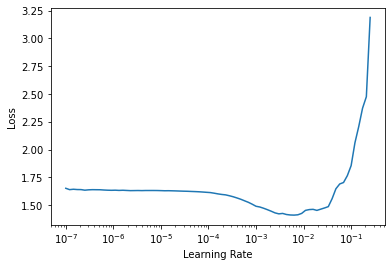

In [19]:
learn.lr_find()

## Training with flat + consine annealing

In [20]:
learn.fit_flat_cos(15,lr=8e-4,pct_start=0,cbs=[EarlyStoppingCallback(patience=3),SaveModelCallback(monitor='accuracy'),CutMix()])

epoch,train_loss,valid_loss,accuracy,time
0,0.884474,0.836829,0.780322,11:45
1,0.828640,0.703805,0.857443,11:33
2,0.800224,0.682671,0.864688,11:34
3,0.775186,0.679456,0.863286,11:34
4,0.755760,0.679936,0.859547,11:34
5,0.750432,0.642215,0.882683,11:34
6,0.753344,0.643226,0.878009,11:34
7,0.708910,0.635551,0.887123,11:33
8,0.711054,0.621648,0.888993,11:34
9,0.688616,0.615777,0.893900,11:32


Better model found at epoch 0 with accuracy value: 0.7803224921226501.
Better model found at epoch 1 with accuracy value: 0.8574433326721191.
Better model found at epoch 2 with accuracy value: 0.8646880388259888.
Better model found at epoch 5 with accuracy value: 0.8826828598976135.
Better model found at epoch 7 with accuracy value: 0.887123167514801.
Better model found at epoch 8 with accuracy value: 0.8889927268028259.
Better model found at epoch 9 with accuracy value: 0.893900454044342.
Better model found at epoch 10 with accuracy value: 0.8953026533126831.
Better model found at epoch 11 with accuracy value: 0.9009114503860474.
Better model found at epoch 12 with accuracy value: 0.9020799398422241.
Better model found at epoch 13 with accuracy value: 0.9027810096740723.


## Exporting our model for inference

In [21]:
learn.export('my_model_2')